<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/recession_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download files and install packages

In [ ]:
import requests
def download_file(url):
  fn = url.split('/')[-1]
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)

download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/peakdetect.py')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/lith.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/dry_discharge.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/elder_discharge.csv')
!pip install -q geopandas

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 16.7 MB 235 kB/s 
     |████████████████████████████████| 6.3 MB 33.4 MB/s 


# Imports and function definitions

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
%matplotlib inline
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
import geopandas as gp
import glob
import matplotlib
import pickle
import urllib3
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

def getArea(site):
    link = 'https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=' + site
    webp=urllib.request.urlopen(link).read().decode()
    key = 'Drainage area: '
    idx = webp.find(key) + len(key)
    area = float(webp[idx:(idx+10)].split(' ')[0])
    return area



def qd(t, q0, a, b):
    return (q0**(1-b) - a*(1-b)*t)**(1/(1-b))

def getAB(d,linear=False,option=1,start = 0,selectivity = 100,ante = 1,
    window = 3,minLen = 5,alph = .9,a0 = 1e-2,b0 = 1.5): 
  d = pd.DataFrame(d.values,columns=['q'],index=d.index)
  selector = (d.q.max()-d.q.min())/selectivity
  datelist = d.index.tolist()
  d.index = range(len(d))
  [maxtab, mintab]=peakdet(d.q, selector)
  #initialize peaks
  d['peaks']=-1
  #get rid of peaks too close to the start
  if ante>2:
      maxtab = maxtab[maxtab[:,0].astype(int)>ante]
  else:
      maxtab = maxtab[maxtab[:,0].astype(int)>1]
  d.loc[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]
  d['smooth']= d.q.rolling(window).mean()
  d['smooth'][0:2] = d.q[0:2]
  d['Dunsmooth']= d.q.diff().shift(-1)
  d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
  d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
  d = d[:-2]
  #boolean vector for recession periods 
  if option==0:
      d['choose'] = d['Dunsmooth']<=0
  else:
      d['choose'] = (d['Dunsmooth']<=0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))
  datesMax = d.loc[d['peaks']>0].index
  a = []
  b = []
  startDates = []
  for i in np.arange(len(datesMax)-1):
      recStart = datesMax[i] 
      peak1 = datesMax[i]
      peak2 = datesMax[i+1]
      recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
      if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
          continue
      t = np.arange(len(d.values[recStart:recEnd]))
      q0 = d.q[recStart]
      try:
          if linear:
              qq = d.q[recStart:recEnd]
              popt = np.polyfit(np.log(qq[1:]),np.log(-np.diff(qq)),1)
              popt = [np.exp(popt[1]), popt[0]]            
          else:
              popt, cov = curve_fit(lambda t, a, b: qd(t, q0, a, b), t, d.q[recStart:recEnd], p0=[a0,b0])
              
          a.append(popt[0])
          b.append(popt[1])
          startDates.append(datelist[datesMax[i]])
      except RuntimeError:
          continue
  a = np.array(a)
  b = np.array(b)
  df = pd.DataFrame({'a':a,'b':b})
  df = df.set_index(pd.to_datetime(startDates))
  return df

def get_recession_linear(dataframe, returnmean=True):
    selectivity = 50.
    minLen = 4
    start = 0
    option = 1
    alph = 0.9
    ante = 0
    window = 3
    def func(t, q0, k):
        return q0*np.exp(-k*t)
    Ks = []
    d = pd.DataFrame(dataframe.values,columns=['q'])
    selector = (d.q.max()-d.q.min())/selectivity
    [maxtab, mintab]=peakdet(d.q, selector)
    #initialize peaks
    d['peaks']=-1
    #get rid of peaks too close to the start
    if ante>2:
        maxtab = maxtab[maxtab[:,0].astype(int)>ante]
    else:
        maxtab = maxtab[maxtab[:,0].astype(int)>1]
    d.loc[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]
    d['smooth']= d.q.rolling(window=window).mean(); d['smooth'][0:2] = d.q[0:2]
    d['Dunsmooth']= d.q.diff().shift(-1)
    d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
    d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
    d = d[:-2]
    #boolean vector for recession periods 
    if option==0:
        d['choose']=d['Dunsmooth']<=0
    else:
        d['choose']=(d['Dunsmooth']<=0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))
    datesMax = d.loc[d['peaks']>0].index
    for i in np.arange(len(datesMax)-1):
        recStart = datesMax[i]+start; peak1 = datesMax[i]+start; peak2 = datesMax[i+1]
        if peak1>=peak2: 
            continue 
        recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
        if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
            continue
        t = np.arange(len(d.q[recStart:recEnd]))
        q0 = d.q[recStart]
        try:
            popt, cov = curve_fit(func,t,d.q[recStart:recEnd])
        except RuntimeError:
            print('Error encountered in fitting')
            continue
        Ks.append(popt[1])
    if returnmean:
        return np.mean(Ks)
    else:
        return np.median(Ks)

In [ ]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    try: 
      geoms = [item for item in list(basin.geometry[0])]
      idx = np.argmax([item.area for item in geoms])
      basin.geometry = [geoms[idx]]
      print('Found multipolygon - fixing')
    except:
      basin.geometry = basin.geometry
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2    
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin


# Download and compile flow data

In [ ]:
gageNumsToNames = {
                   '11475800':'Eel, Leggett',
                   '11475560':'Elder Creek',
                   '11478500':'Van Duzen',
                   '00000000':'Dry Creek',
                   '11472200':'Outlet Creek',
                    }

gagelist = ['11475560','11472200','11478500','11475800']
gagelist_streams = ['11475560','11472200','11478500','11475800']


startyear = '1950'
endyear = '2019'
startdate = startyear + '-01-01'
enddate = endyear + '-12-31'
basins = []
dfs = []
for gage in gagelist:
  df, basin = getFlow(gage,startdate, enddate)
  dfs.append(df)
  basins.append(basin.geometry[0])

# dataframe of flows
flow = pd.concat(dfs,axis=1)

gdf = gp.GeoDataFrame(geometry=basins,crs='epsg:4326')
gdf['gage'] = gagelist
gdf['name'] = gdf.gage.map(gageNumsToNames)

streams = []
for gage in gagelist: 
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UT/flowlines?distance=999'%gage
  temp = gp.read_file(url)
  streams = streams + temp.geometry.tolist()

streams = gp.GeoDataFrame(geometry=streams,crs='epsg:4326')

mains = []
for gage in gagelist: 
  if gage=='11475560':
    continue
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UM/flowlines?distance=35'%gage
  temp = gp.read_file(url)
  mains = mains + temp.geometry.tolist()

mains = gp.GeoDataFrame(geometry=mains)

# add Dry Creek data, gage=00000000
lith = pd.read_csv('./lith.csv',index_col=0)
lith.index = lith.index.astype(str)
lith = lith.append(pd.DataFrame([1.0], columns=['melange'], index=['00000000']))
dry = pd.read_csv('./dry_discharge.csv',index_col=0,parse_dates=True)
dry = dry.resample('D').mean()
dry.columns = ['00000000']
gagelist.append('00000000')
flow = pd.concat([flow,dry],axis=1)

In [ ]:
gagelist_streams = ['11475560','11472200','11478500','11475800', '11477000','11476500']

bas = []
for gage in gagelist_streams:
  df, basin = getFlow(gage,'1950-01-01', '2000-02-01')
  # dfs.append(df)
  bas.append(basin.geometry[0])

gdf = gp.GeoDataFrame(geometry=bas,crs='epsg:4326')
gdf['gage'] = gagelist_streams

streams = []
for gage in gagelist_streams: 
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UT/flowlines?distance=999'%gage
  temp = gp.read_file(url)
  streams = streams + temp.geometry.tolist()

streams = gp.GeoDataFrame(geometry=streams,crs='epsg:4326')

mains = []
for gage in gagelist_streams: 
  if gage=='11475560':
    continue
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UM/flowlines?distance=35'%gage
  temp = gp.read_file(url)
  mains = mains + temp.geometry.tolist()

mains = gp.GeoDataFrame(geometry=mains)
gdf.to_file('./all_catchments.geojson')
streams.to_file('./all_streams.geojson')
mains.to_file('./all_mains.geojson')

In [ ]:
basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%'11479560')
basin.to_file('./eel_wb.geojson')

In [ ]:


bas = []
for gage in gagelist_streams:
  df, basin = getFlow(gage,'1950-01-01', '2000-02-01')
  # dfs.append(df)
  bas.append(basin.geometry[0])

gdf = gp.GeoDataFrame(geometry=bas,crs='epsg:4326')
gdf['gage'] = gagelist_streams

streams = []
for gage in gagelist_streams: 
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UT/flowlines?distance=999'%gage
  temp = gp.read_file(url)
  streams = streams + temp.geometry.tolist()

streams = gp.GeoDataFrame(geometry=streams,crs='epsg:4326')

mains = []
for gage in gagelist_streams: 
  if gage=='11475560':
    continue
  url = 'https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/navigation/UM/flowlines?distance=35'%gage
  temp = gp.read_file(url)
  mains = mains + temp.geometry.tolist()

mains = gp.GeoDataFrame(geometry=mains)
gdf.to_file('./eel_wb.geojson')
# streams.to_file('./all_streams.geojson')
# mains.to_file('./all_mains.geojson')

# Perform recession analysis

In [ ]:
winterOnly=True
linear=False
dfs = []
flowdfs = []
Ks = {}
cs = sns.color_palette('Set2',5)
deg = 1
for i,gage in enumerate(gagelist):
  temp = flow[[gage]].copy()
  flowdfs.append(temp)
  df = getAB(temp[gage],linear)
  Ks[gage] = get_recession_linear(temp[gage], returnmean=False)
  if winterOnly: df = df.loc[(df.index.month<=4)|(df.index.month>=10)]
  df = df.loc[df.a > 0,]
  df = df.loc[df.b > 0,]
  df = df.loc[df.b < 10,]
  df['gage'] = gage
  df['melange'] = lith.loc[gage,'melange']
  df['date'] = df.index
  df.reset_index()
  dfs.append(df)
recessions = pd.concat(dfs, ignore_index=True)

params_data = pd.DataFrame([{'n':len(recessions[recessions.gage == gage].b),
                   'stdB':np.std(recessions[recessions.gage == gage].b),
                   'medB':np.median(recessions[recessions.gage == gage].b),
                   'stdA':np.std(recessions[recessions.gage == gage].a),
                   'medA':np.median(recessions[recessions.gage == gage].a),                    
                   'gage':gage, 
                   'meanq':flow.loc[(flow.index.month<=4)|(flow.index.month>=10)][gage].mean(),
                    'medq':flow.loc[(flow.index.month<=4)|(flow.index.month>=10)][gage].median(), 'tau':1/Ks[gage],
                   'melange':float(lith.loc[gage,'melange'])} for gage in flow.columns],
                   )
params_data = params_data.sort_values('melange')
params_data = params_data.sort_values('melange').reset_index()

# Calculate annual statistics

In [ ]:
rainfall = pd.read_csv('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/ppt.csv',index_col=0,parse_dates=True)
rows = []
dfs = []
for gage in flow.columns:
  df = flow[[gage]].copy()
  df.columns=['q']
  df['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in df.index]
  rain = rainfall[[gage]]
  rain['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]
  sumsum = lambda tempdf: tempdf[(tempdf.index.month>=6)&(tempdf.index.month<=8)].q.sum()
  annualsum = lambda tempdf: tempdf.q.sum()
  getlen = lambda tempdf: np.sum(np.isfinite(tempdf.q))

  # summer runoff fraction
  qSum = df.groupby('wy').apply(sumsum)/df.groupby('wy').apply(annualsum)
  qAnnual = df.groupby('wy').apply(annualsum)
  lens = df.groupby('wy').apply(getlen)
  qSum = qSum[lens>300]
  rain_annual = rain.groupby('wy').mean()
  rr = qAnnual[lens>300].mean()/(rain_annual[lens>300][gage].mean()*365)

  mean_summer_runoff_fraction = qSum.mean()
  stderr = qSum.std()/np.sqrt(len(qSum))
  rows.append([gage,mean_summer_runoff_fraction,stderr,rr])

# create dataframe and merge with lithology breakdown
df = pd.DataFrame(rows)
df.columns = ['gage','qSummerMean','qSummerStdErr','rr']
df = df.set_index('gage')
x = pd.concat([lith, df],axis=1, join='inner')

# Plot exemplary year and recession = f(lithology)

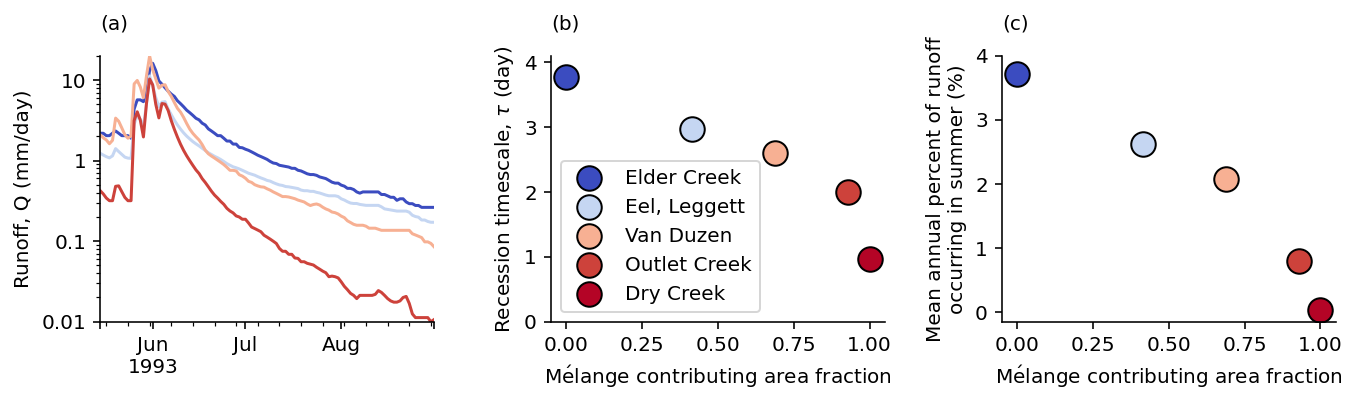

In [ ]:
year = 1993
f,axs = plt.subplots(1,3,figsize=(9.6,3.))
ax = axs[0]
x = x.sort_values('melange')
cmap = matplotlib.cm.get_cmap('coolwarm',)
tempflow = flow.copy()
ax.set_yscale('log')

for i,row in x.iterrows():
  c = np.array(cmap(row.melange))
  if i=='00000000':
    tau =  params_data.loc[params_data.gage==i].tau.values[0]
    axs[1].scatter(row.melange,tau,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
    axs[2].scatter(row.melange,100*row.qSummerMean,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
    t = np.linspace(0,10)
    y = np.exp(-t/tau)
    continue
  else:
    tempflow[i].loc['05-15-%s'%str(year):'8-%s'%str(year)].plot(ax=ax,c=c)

  tau =  params_data.loc[params_data.gage==i].tau.values[0]
  axs[1].scatter(row.melange,tau,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
  axs[2].scatter(row.melange,100*row.qSummerMean,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])

ax.set_yscale('log')
ax.set_ylabel('Runoff, Q (mm/day)')
ax.set_xlabel('')
ax.text(0,1.1,'(a)',transform=ax.transAxes)
ax.set_ylim([1e-2,2e1])
import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


ax = axs[1]
ax.set_ylabel(r'Recession timescale, $\tau$ (day)')
ax.set_xlabel(r'M$\'{\mathrm{e}}$lange contributing area fraction')
ax.text(0,1.1,'(b)',transform=ax.transAxes)
# ax.set_ylim([0.2,1.0])
ax.set_ylim([0.0,4.1])
ax.legend()

ax = axs[2]
ax.set_ylim([-0.15,4])
ax.set_ylabel('Mean annual percent of runoff\noccurring in summer (%)')
ax.set_xlabel(r'M$\'{\mathrm{e}}$lange contributing area fraction')
ax.text(0,1.1,'(c)',transform=ax.transAxes)
f.tight_layout()
sns.despine(fig=f)
f.savefig('./recession_qfrac.pdf')